# Task
Analyze an experiment where the guest is required to write a message that is at least 140 characters long to explain why he or she is interested is staying with the host. This is run as a 50-50 experiment (50% in treatment, 50% in control).  

What happens to the experience of contacting and booking a place on Airbnb when the guest is required to write a message like this?

What should we do with change, expand to all or cancel?

How would you explain the results to someone who is not highly technical?

# Summary
Given this data, I would conclude that the experiment was implemented incorrectly and/or users were completely uninfluenced by the change. I saw no difference in the length of messages being sent, and no significant difference in either booking flow nor user behavior. I would recommend first double-checking that the test was implemented correctly. 

# Analysis
I first checked to see if the experiment cells were indeed allocated 50/50, which they were. I then compared the distribution of message length between the treatment and control cells, and saw no difference. At the very least, I would expect to see that the population in the treatment cell sent close to 0 messages that were less than 140 characters, but instead the proportion of messages between the two cells were similar. 

For the sake of this exercise, I proceeded as if the change were implemented correctly. I narrowed my analysis to the inquiries that used the 'contact_me' channel, and compared the following user outcomes:

* Difference in % inquries replied to (p-value of 28.2%, not significant)

* Difference in % inquiries accepted (p-value of 69.8%, not significant)

* Difference in % inquiries booked (p-value of 56.8%, not significant)

(1)

I then looked to see if the experiment had changed the following user behavior:

* Difference in mean number inquiries per guest (p-value of 92.9%, not significant)
(2) 

* Median response time to inquiry (p-value of 98.8%, not significant)
(3)

I saw no significant differences in any of these comparisons, leading me to believe that the test was not correctly implemented. 

(1) Using the Fisher exact test

(2) Using Welch's t-test

(3) Using Mood's median test

\*In general, when we compare a statistic (such as a percent of successes or a mean) between two populations, we also want an estimate of how often we would see a significant result, given that these populations were randomly chosen/assigned. We can estimate significance by computing how much these statistics would move by chance, and then computing what percentage of the time we would see the result we found. Low p-values (less than 5%) suggest that what we found is likely not the result of chance, and therefore meaningful. 

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import fisher_exact, ttest_ind, chi2_contingency, chisquare, median_test
from IPython.display import display, HTML

%matplotlib inline

In [ ]:
# Helper functions

def plot_metric(data, metric_name):
    control_idx = graph_data['cell'] == 'control'
    treatment_idx = graph_data['cell'] == 'treatment'
    control = graph_data[control_idx].set_index('month')
    treatment = graph_data[treatment_idx].set_index('month')

    x = np.arange(0, 12, 1)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 7)
    ax1.fill_between(x, 
                     treatment["{}_05_rate".format(metric_name)], 
                     treatment["{}_95_rate".format(metric_name)],
                     alpha=0.7,
                     color=current_palette[0],
                     label='treatment')
    ax1.fill_between(x, 
                     control["{}_05_rate".format(metric_name)], 
                     control["{}_95_rate".format(metric_name)],
                     alpha=0.7,
                     color=current_palette[1],
                     label='control')

    plt.xticks(x, control.index, rotation=40)
    ax1.set_xlim([0,11])
    plt.title(metric_name)
    plt.xlabel('Date')
    plt.ylabel(' Cumulative rate')
    plt.legend()
    
def bootstrap(dataframe, number_of_samples):
    sample_stats = []
    keys = ['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
    indexes = np.random.choice(dataframe.index, [number_of_samples, len(dataframe.index)], replace=True)
    for i in indexes:
        sample = dataframe.loc[i, :]
        stats = {k:sample[k].count() for k in keys}
        sample_stats.append(stats)
    return pd.DataFrame.from_records(sample_stats)

def get_conf_intervals(dataframe, label):
    keys = ['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
    stats = {'cell': label}
    for k in keys:
        stats["{}_mean".format(k)] = dataframe[k].mean()
        stats["{}_05".format(k)] = dataframe[k].quantile(0.05)
        stats["{}_95".format(k)] = dataframe[k].quantile(0.95)
    return pd.DataFrame.from_records([stats])

## Data

In [616]:
# import
assignments = pd.read_csv('Airbnb/takehome_assignments.csv')
print assignments.shape
contacts = pd.read_csv('Airbnb/takehome_contacts.csv')
print contacts.shape

# clean
# take out users assigned to multiple groups
assignments = assignments.groupby('id_user').filter(lambda x: x['ab'].nunique() == 1)
# remove duplicate assignments
assignments = assignments.groupby(['id_user', 'ab']).agg('count').reset_index()

# merge
data = contacts.merge(assignments, left_on='id_guest', right_on='id_user')
print data.shape

# transform
data['ts_interaction_first'] = pd.to_datetime(data['ts_interaction_first'])
data['ts_reply_at_first'] = pd.to_datetime(data['ts_reply_at_first'])
data = pd.concat([data, pd.get_dummies(data['ab'])], axis=1)
data['ts_interaction_first_month'] = data['ts_interaction_first'].apply(lambda x: '{}-{:02}'.format(x.year, x.month))

# subsets
all_data = data
idx = data['dim_contact_channel'] == 'contact_me'
contact_data = all_data[idx]

(10000, 2)
(10000, 9)
(9104, 11)


## Data overview

In [259]:
# Guest attempts per channel
pd.pivot_table(all_data, 
               values='id_guest', 
               index='ts_interaction_first_month', 
               columns='dim_contact_channel', 
               aggfunc='count').fillna(0)

dim_contact_channel,book_it,contact_me,instant_booked
ts_interaction_first_month,,,
2013-01,83,450,1
2013-02,81,497,4
2013-03,95,670,1
2013-04,119,772,5
2013-05,136,840,0
2013-06,135,755,2
2013-07,207,755,3
2013-08,251,715,8
2013-09,228,585,2


In [538]:
# Guest outcomes
(all_data.set_index('ts_interaction_first')
         .resample('M', {'id_guest':'count',
                         'ts_reply_at_first':'count',
                         'ts_accepted_at_first':'count',
                         'ts_booking_at':'count'}))

,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,id_guest
ts_interaction_first,,,,
2013-01-31,476,204,130,534
2013-02-28,509,203,124,582
2013-03-31,678,262,178,766
2013-04-30,744,275,172,896
2013-05-31,811,289,191,976
2013-06-30,731,272,168,892
2013-07-31,815,322,213,965
2013-08-31,833,349,240,974
2013-09-30,717,297,199,815


## Was the experiment done correctly?

In [596]:
# Were the control/treatment allocations skewed in any way? 

how = {'control':'sum', 'treatment':'sum'}
monthly = all_data.set_index('ts_interaction_first').resample('M', how=how)
display(monthly)
chi2, p, dof, expected = chi2_contingency(monthly)
print "With a p-value of {:.1f}%, the experiment allocations are not significantly skewed".format(p * 100)

,control,treatment
ts_interaction_first,,
2013-01-31,285,249
2013-02-28,285,297
2013-03-31,366,400
2013-04-30,459,437
2013-05-31,476,500
2013-06-30,452,440
2013-07-31,490,475
2013-08-31,490,484
2013-09-30,391,424


With a p-value of 66.9%, the experiment allocations are not significantly skewed


In [593]:
display(contact_data.groupby('ab', as_index=False).agg({'id_listing':'count', 'm_first_message_length':'median'}))
print "I would expect the treatment group to have a lower median message length."

,ab,id_listing,m_first_message_length
0,control,3648,289
1,treatment,3642,287


I would expect the treatment group to have a lower median message length.


There are still users in the treatment group sending messages < 140 characters.
The test does not appear to be implemented correctly.
However, for this exercise I will proceed as if it were.


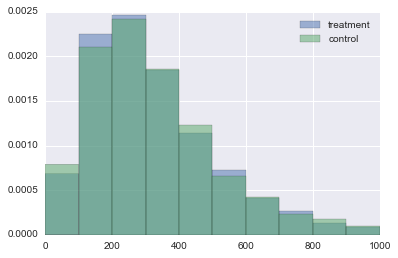

In [551]:
# What happened to message length? 
# Expect to see no first messages < 140

control_idx = contact_data['ab'] == 'control'
treatment_idx = contact_data['ab'] == 'treatment'
bins = [0,100,200,300,400,500,600,700,800,900,1000]
plt.hist(contact_data.loc[treatment_idx, 'm_first_message_length'], bins=bins, alpha=0.5, normed=1, label='treatment')
plt.hist(contact_data.loc[control_idx, 'm_first_message_length'], bins=bins, alpha=0.5, normed=1, label='control')
plt.legend()
print "There are still users in the treatment group sending messages < 140 characters."
print "The test does not appear to be implemented correctly."
print "However, for this exercise I will proceed as if it were."

In [598]:
contact_data['message_lt_140'] = np.nan
contact_data['message_bt_140_300'] = np.nan
idx = contact_data['m_first_message_length'] < 140
contact_data.loc[idx, 'message_lt_140'] = 1
idx = (contact_data['m_first_message_length'] >= 140) & (contact_data['m_first_message_length'] < 300)
contact_data.loc[idx, 'message_bt_140_300'] = 1
stats = contact_data.groupby('ab').agg({'message_lt_140':'sum',
                                'message_bt_140_300': 'sum',
                                'id_listing':'count'})
stats['message_lt_140_pct'] = stats['message_lt_140'] / stats['id_listing']
stats['message_bt_140_300_pct'] = stats['message_bt_140_300'] / stats['id_listing']
display(stats)
print "Oftentimes hard limits are reflected in user behavior"
print "(ie, a large spike in activity right above the hard limit of 140 char)"
print "but not so here."

/Users/agtsai/anaconda/envs/yewno/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/agtsai/anaconda/envs/yewno/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,id_listing,message_bt_140_300,message_lt_140,message_lt_140_pct,message_bt_140_300_pct
ab,,,,,
control,3648,1355,542,0.148575,0.371436
treatment,3642,1435,494,0.135640,0.394014


Oftentimes hard limits are reflected in user behavior
(ie, a large spike in activity right above the hard limit of 140 char)
but not so here.


## Experiment Outcome

### How did users do in the booking flow?

In [591]:
# current status with all data
pipeline = contact_data.groupby('ab').agg({'id_guest': 'count', 
                        'ts_interaction_first':'count',
                        'ts_reply_at_first':'count',
                        'ts_booking_at':'count',
                        'ts_accepted_at_first':'count'})

pipeline = pipeline[['id_guest', 'ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']]
display(pipeline)

keys = ['ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
for k in keys:
    complement = pipeline['id_guest'] - pipeline[k]
    contingency_table = pd.concat([pipeline[k], complement], axis=1)
    odds_ratio, p_value = fisher_exact(contingency_table)
    print "p-value for {}: {:.1f}%".format(k, p_value * 100)
    
print "---"
print "Using the Fisher exact test to compare the control and independent cells,"
print "none of the steps in the booking flow show a statistically significant difference."

,id_guest,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at
ab,,,,,
control,3648,3648,3076,1059,507
treatment,3642,3642,3104,1042,524


p-value for ts_reply_at_first: 28.2%
p-value for ts_accepted_at_first: 69.8%
p-value for ts_booking_at: 56.8%
---
Using the Fisher exact test to compare the control and independent cells,
none of the steps in the booking flow show a statistically significant difference.


### Test power

In [584]:
NUMBER_OF_SAMPLES=1000

# flatten to unique guests, as some have multiple booking attempts
unique_guests = contact_data.groupby('id_guest', as_index=False).agg({'ts_interaction_first':'count',
                                                                      'ts_reply_at_first':'count',
                                                                      'ts_accepted_at_first':'count',
                                                                      'ts_booking_at':'count'})

# Bootstrap these people
control_idx = contact_data['ab'] == 'control'
treatment_idx = contact_data['ab'] == 'treatment'
control_bootstrap = bootstrap(contact_data[control_idx].reset_index(drop=True), number_of_samples=NUMBER_OF_SAMPLES)
treatment_bootstrap = bootstrap(contact_data[treatment_idx].reset_index(drop=True), number_of_samples=NUMBER_OF_SAMPLES)
control_sample_stats = get_conf_intervals(control_bootstrap, label='control')
treatment_sample_stats = get_conf_intervals(treatment_bootstrap, label='treatment')
ci = pd.concat([control_sample_stats, treatment_sample_stats], axis=0).set_index('cell')

print "For reference, we have collected enough samples to detect a "
keys = ['ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
for k in keys:
    effect_size = ci.loc['treatment', '{}_95'.format(k)] - ci.loc['treatment', '{}_mean'.format(k)]
    print "\t{:.1f}%+ change in {}".format(effect_size / ci.loc['control', '{}_mean'.format(k)] * 100, k)
print "with 95% confidence, if that difference existed."

For reference, we have collected enough samples to detect a 
	1.1%+ change in ts_reply_at_first
	4.4%+ change in ts_accepted_at_first
	7.1%+ change in ts_booking_at
with 95% confidence, if that difference existed.


### Booking ratios over time

For fun, here are some graphs!

Each graph shows the 95% confidence interval of the cumulative percentage of the given metric up through a given month. For example, the March value for "ts_reply_at_first" is for all data up to and including March. The benefit of a cumulative percentage is that it can give a sense of when a test will converge (if ever), due to the increased samples narrowing the confidence band. 

In [585]:
NUMBER_OF_SAMPLES=500

monthly_data = []
for month in contact_data['ts_interaction_first_month'].unique():
    idx = contact_data['ts_interaction_first_month'] <= month
    data = contact_data[idx].reset_index(drop=True)
    monthly_data.append(data)

monthly_stats = []
for monthly in monthly_data:
    # split into control and treatment
    control_idx = monthly['ab'] == 'control'
    treatment_idx = monthly['ab'] == 'treatment'
    
    # bootstrap
    control_bootstrap = bootstrap(monthly[control_idx].reset_index(drop=True), number_of_samples=NUMBER_OF_SAMPLES)
    treatment_bootstrap = bootstrap(monthly[treatment_idx].reset_index(drop=True), number_of_samples=NUMBER_OF_SAMPLES)
    
    control_sample_stats = get_conf_intervals(control_bootstrap, label='control')
    treatment_sample_stats = get_conf_intervals(treatment_bootstrap, label='treatment')
    
    ci = pd.concat([control_sample_stats, treatment_sample_stats], axis=0).reset_index(drop=True)
    ci['month'] = monthly['ts_interaction_first_month'].max()
    monthly_stats.append(ci)
    
graph_data = pd.concat(monthly_stats, axis=0).sort_values(by='month', ascending=True)
base = ['ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
bounds = ['05', 'mean', '95']
keys = ["{}_{}".format(i, j) for i in base for j in bounds]
for k in keys:
    graph_data["{}_rate".format(k)] = graph_data[k] / graph_data['ts_interaction_first_mean'] 

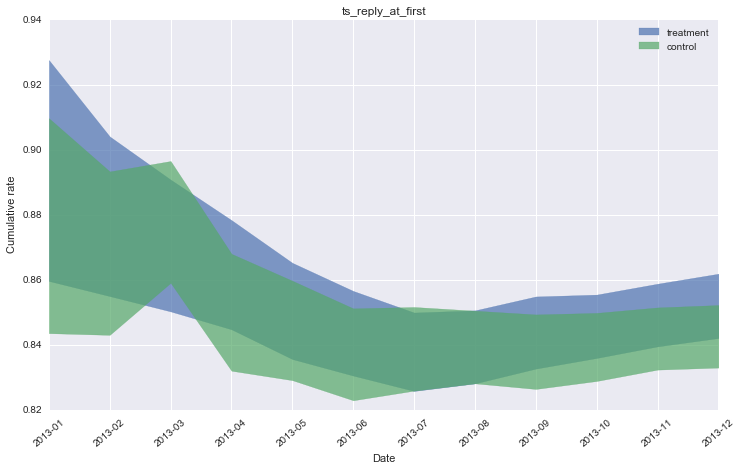

In [587]:
plot_metric(graph_data, 'ts_reply_at_first')

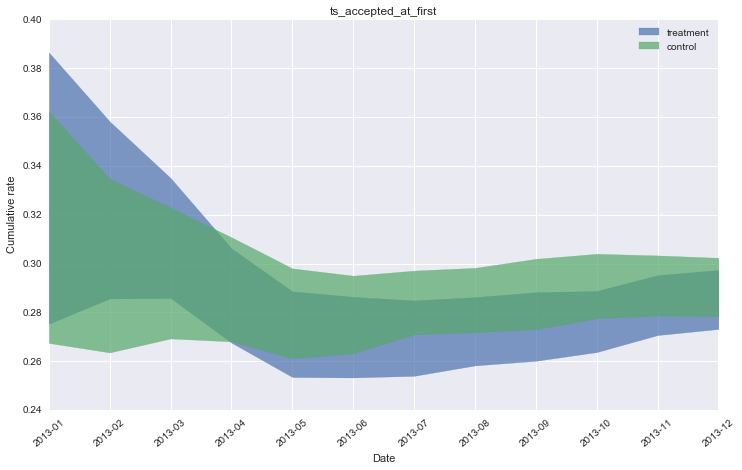

In [588]:
plot_metric(graph_data, 'ts_accepted_at_first')

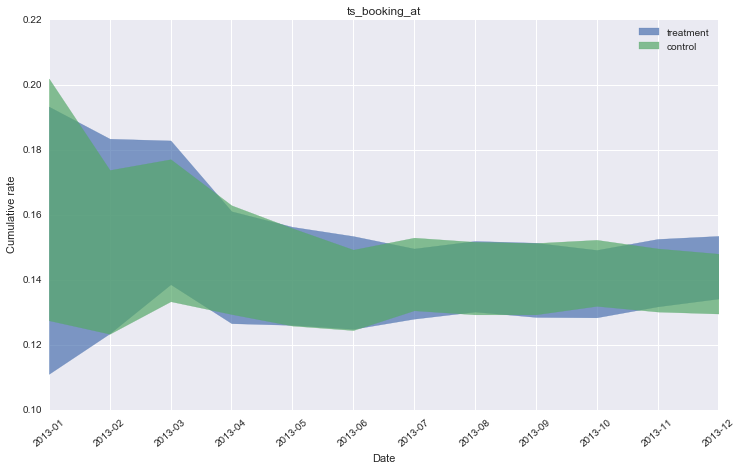

In [589]:
plot_metric(graph_data, 'ts_booking_at')

### Did user behavior change?

In [719]:
# Welch's t-test

print "Did guests reach out to fewer listings because of the message requirement?"
user_attempts = contact_data.groupby(['id_guest', 'ab'], as_index=False).agg({'id_listing':'nunique'})
attempt_stats = user_attempts.groupby('ab').agg({'id_listing':'mean'})
control_mean = attempt_stats.loc['control', 'id_listing']
treatment_mean = attempt_stats.loc['treatment', 'id_listing']
print "Mean control contacts: {:.4f}".format(control_mean)
print "Mean treatment contacts: {:.4f}".format(treatment_mean)
print "Difference: {:.2f}".format(control_mean - treatment_mean)

control_idx = user_attempts['ab'] == 'control'
treatment_idx = user_attempts['ab'] == 'treatment'
statistic, p_value = ttest_ind(user_attempts.loc[control_idx, 'id_listing'],
          user_attempts.loc[treatment_idx, 'id_listing'],
          equal_var=False)
print "No. This difference has a p-value of {:.1f}%".format(p_value * 100)

Did guests reach out to fewer listings because of the message requirement?
Mean control contacts: 1.0513
Mean treatment contacts: 1.0508
Difference: 0.00
No. This difference has a p-value of 92.9%


In [704]:
# Mood's median test

print "Did response time change because of the new requirement?"
contact_data['response_time'] = (contact_data['ts_reply_at_first'] - contact_data['ts_interaction_first']) / np.timedelta64(1, 's')
response_rates = contact_data.groupby('ab').agg({'response_time':'median'})
control_response_time = response_rates.loc['control', 'response_time']
treatment_response_time = response_rates.loc['treatment', 'response_time']
diff = control_response_time - treatment_response_time
print "Median control response time (seconds): {:2f}".format(control_response_time)
print "Median treatment response time (seconds): {:2f}".format(treatment_response_time)
print "The treatment response rate is {} seconds faster ({:.2f})%.".format(diff, diff / (control_response_time + treatment_response_time) * 100)

response_idx = contact_data['response_time'].notnull()
control_idx = (contact_data['ab'] == 'control') & response_idx
treatment_idx = (contact_data['ab'] == 'treatment') & response_idx
statistic, p_value, m, table = median_test(contact_data.loc[control_idx, 'response_time'],
          contact_data.loc[treatment_idx, 'response_time'])
print "Not a significant difference ({:.1f}%)".format(p_value * 100)

Did response time change because of the new requirement?
Median control response time (seconds): 15744.000000
Median treatment response time (seconds): 15688.500000
The treatment response rate is 55.5 seconds faster (0.18)%.
Not a significant difference (98.0%)


/Users/agtsai/anaconda/envs/yewno/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
